In [98]:
import pandas as pd

def read_act_df(base_dir, time_cols=['Started', 'Finished', 'Updated']):
    """
    Load csv file containing activity data and parse datetime columns.
    Drop rows with NaN in specified time columns.
    Args:
        base_dir (str): Path to the CSV file.
        time_cols (list): List of columns to parse as datetime.
    Returns:
        pd.DataFrame: DataFrame with parsed datetime columns."""
    act_df = pd.read_csv(base_dir)
    act_df = act_df.dropna(subset=time_cols)

    for col in time_cols:
        act_df[col] = pd.to_datetime(act_df[col], format='%Y/%m/%d %H:%M')
        if act_df[col].isna().any():
            raise ValueError(f"Column '{col}' contains NaN or unparseable datetime values.")
        act_df[col] = act_df[col].dt.tz_localize('UTC+09:00')

    return act_df

act_path = '../data/TrainingDataPD25/TrainActivities.csv'
act_df = read_act_df(act_path)

In [99]:
import os
import glob

base_dir = '/Users/tptn/MachineLearning/tremor_challenge2/data/TrainingDataPD25/users_timeXYZ/users'
headers = ['id', 'datetime', 'x', 'y', 'z']

def read_users_df(base_dir, headers):
    """
    Load all csv files into one DataFrame.
    Parse datetime and ensure timezone consistency.
    Sort by datetime.
    Args:
        base_dir (str): Base directory containing user data.
        headers (list): List of column names for the DataFrame.
    Returns:
        pd.DataFrame: Concatenated DataFrame with all user data."""
    df_list = [] # to store all csv files
    for id in os.listdir(base_dir):
        path = os.path.join(base_dir, id)

        if os.path.isdir(path):
            files = glob.glob(os.path.join(path, '*.csv'))

            for f in files:
                df = pd.read_csv(f, header=None, names=headers) # load csv
                df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%dT%H:%M:%S.%f%z') # conver to datetime
                tz = df['datetime'].dt.tz # get the timezone
                if tz != 'UTC+09:00':
                    df['datetime'] = df['datetime'].dt.tz_convert('UTC+09:00')
                df_list.append(df)
    users_df = pd.concat(df_list, ignore_index=True)
    users_df.sort_values(by=['datetime'], inplace=True)
    return users_df

users_df = read_users_df(base_dir, headers)

In [100]:
def add_duration(act_df):
    """Add duration between 'Started' and 'Finished' columns to the activity DataFrame."""
    act_cp = act_df.copy()
    act_cp['Finished'] = act_cp['Finished'].dt.floor('s') + pd.Timedelta(minutes=1) - pd.Timedelta(microseconds=1)
    return act_cp

act_df = add_duration(act_df)

In [102]:
def seg_acc_per_act(acc_df, act_df):
    seg_list=[]
    seg_label_list=[]
    seg_id_list=[]
    seg_subject_list=[]

    for index, row in act_df.iterrows():
        start = row['Started']
        end = row['Finished']

        seg = acc_df[acc_df['datetime'].between(start, end)]
        seg_id = row['ID']
        seg_label = row['Activity Type']
        seg_subject = row['Subject']
        if not seg.empty:
            seg_list.append(seg)
            seg_label_list.append(seg_label)
            seg_id_list.append(seg_id)
            seg_subject_list.append(seg_subject)

    return seg_list, seg_label_list, seg_id_list, seg_subject_list

seg_list, seg_label_list, seg_id_list, seg_subject_list = seg_acc_per_act(users_df, act_df)

# Segment by time window

In [103]:
WSIZE = 1 # in seconds
OVERLAP = 0.5 * WSIZE # % of window size
def seg_by_window(seg_list, seg_label_list, seg_id_list, seg_subject_list, wsize=1, stride=0.5):
    all_seg_list = []
    all_seg_label_list = []
    all_seg_id_list = []
    all_seg_subject_list = []
    for i in range(len(seg_list)):
        acc_df = seg_list[i]
        start = acc_df['datetime'].min()
        end = acc_df['datetime'].max()
        current = start
        window_count = 0
        if (end - start).total_seconds() < wsize:
            continue
        while current + pd.Timedelta(seconds=wsize) <= end:
            seg = acc_df[acc_df['datetime'].between(current, current + pd.Timedelta(seconds=wsize))]
            if not seg.empty:
                window_count += 1
                all_seg_list.append(seg)
                all_seg_label_list.append(seg_label_list[i])
                all_seg_id_list.append(seg_id_list[i])
                all_seg_subject_list.append(seg_subject_list[i])
            current += pd.Timedelta(seconds=wsize * (1 - stride))
    return all_seg_list, all_seg_label_list, all_seg_id_list, all_seg_subject_list

all_seg_list, all_seg_label_list, all_seg_id_list, all_seg_subject_list = seg_by_window(
    seg_list, seg_label_list, seg_id_list, seg_subject_list, wsize=WSIZE, stride=WSIZE-OVERLAP
)

In [44]:
WSIZE = 20  # window size in samples
OVERLAP = 0.5 * WSIZE  # overlap in samples (50% of window size)
def seg_by_sample_window(seg_list, seg_label_list, seg_id_list, seg_subject_list, wsize=20, stride=10):
    all_seg_list = []
    all_seg_label_list = []
    all_seg_id_list = []
    all_seg_subject_list = []

    for i in range(len(seg_list)):
        acc_df = seg_list[i]
        total_samples = len(acc_df)
        j = 0

        # Main sliding window loop
        while j + wsize <= total_samples:
            seg = acc_df.iloc[j:j + wsize]
            all_seg_list.append(seg)
            all_seg_label_list.append(seg_label_list[i])
            all_seg_id_list.append(seg_id_list[i])
            all_seg_subject_list.append(seg_subject_list[i])
            j += stride

        # Last segment: always grab the last `wsize` samples
        if total_samples >= wsize:
            seg = acc_df.iloc[-wsize:]
            all_seg_list.append(seg)
            all_seg_label_list.append(seg_label_list[i])
            all_seg_id_list.append(seg_id_list[i])
            all_seg_subject_list.append(seg_subject_list[i])

    return all_seg_list, all_seg_label_list, all_seg_id_list, all_seg_subject_list

all_seg_list, all_seg_label_list, all_seg_id_list, all_seg_subject_list = seg_by_sample_window(
    seg_list, seg_label_list, seg_id_list, seg_subject_list, wsize=WSIZE, stride=int(WSIZE-OVERLAP)
)

In [104]:
len(all_seg_list), len(all_seg_label_list), len(all_seg_id_list), len(all_seg_subject_list)

(40375, 40375, 40375, 40375)

In [105]:
import numpy as np
from scipy.stats import iqr, skew, kurtosis
from scipy.signal import periodogram

def zero_crossing_rate(signal):
    if len(signal) < 2:
        return 0.0
    return ((signal[:-1] * signal[1:]) < 0).sum() / (len(signal)-1)

def safe_corr(a, b):
    if len(a) < 2 or np.std(a) == 0 or np.std(b) == 0:
        return 0.0
    return np.corrcoef(a, b)[0, 1]

def band_energy(signal, fs=20, low=4, high=6):
    """Compute energy in a frequency band (e.g., 4–6 Hz for tremor)."""
    f, Pxx = periodogram(signal, fs=fs)
    return np.sum(Pxx[(f >= low) & (f <= high)])

def get_feats(df, columns=['x', 'y', 'z']):
    """Method to extract features from acceleration dataframe.
    Returns
    -------
    feats: list of numpy values
        List of features extracted from the acceleration data.
    """
    feats = []
    tremor_band_energies = []

    for col in columns:
        data = df[col].values

        std_ = np.std(data, ddof=0)
        mean_ = np.mean(data)
        max_ = np.max(data)
        min_ = np.min(data)
        median_ = np.median(data)
        iqr_ = iqr(data)
        var_ = np.var(data)
        skew_ = skew(data)
        kurt_ = kurtosis(data)
        ptp_ = np.ptp(data)
        rms_ = np.sqrt(np.mean(data**2))
        zcr_ = zero_crossing_rate(data)

        feats.extend([
            std_, mean_, max_, min_, median_, iqr_,
            var_, skew_, kurt_, ptp_, rms_, 
            zcr_,
        ])

        # Tremor-specific feature (4–6 Hz band energy)
        tremor_energy = band_energy(data)
        tremor_band_energies.append(tremor_energy)

    # Signal Magnitude Area (SMA)
    mag = np.abs(df[columns]).sum(axis=1)
    sma = mag.sum() / len(df)
    feats.append(sma)

    # Axis correlations
    feats.extend([
        safe_corr(df['x'], df['y']),
        safe_corr(df['y'], df['z']),
        safe_corr(df['z'], df['x']),
    ])

    # Append tremor band energy per axis and total
    feats.extend(tremor_band_energies)  # x, y, z band energy
    feats.append(sum(tremor_band_energies))  # total tremor energy

    return feats

In [106]:
feats_list = []
for i, seg in enumerate(all_seg_list):
    feats = get_feats(seg)
    feats_list.append(feats)
    if len(seg['x']) <2:
        print(f'segment {i} column x has less than 2 data points. Something is wrong.')
    if len(seg['y']) <2:
        print(f'segment {i} column y has less than 2 data points. Something is wrong.')
    if len(seg['z']) <2:
        print(f'segment {i} column z has less than 2 data points. Something is wrong.')

segment 16986 column x has less than 2 data points. Something is wrong.
segment 16986 column y has less than 2 data points. Something is wrong.
segment 16986 column z has less than 2 data points. Something is wrong.


In [126]:
from sklearn.model_selection import train_test_split
import numpy as np
X = np.array(feats_list)
y = np.array(all_seg_label_list)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X.shape, y.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

((40375, 44), (40375,), (32300, 44), (32300,), (8075, 44), (8075,))

In [127]:
# save
np.savez('../train_test_set/wsize1s_overlap50.npz', 
        X_train=X_train, X_test=X_test, 
        y_train=y_train, y_test=y_test)
# load 
data = np.load('../train_test_set/wsize1s_overlap50.npz')
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']


In [135]:
df = pd.DataFrame(X_train)
df['label'] = y_train
df.dropna(inplace=True)
X_train = df.drop(columns=['label'])
y_train = df['label']

In [136]:
len(X_train), len(y_train), len(X_test), len(y_test)

(32299, 32299, 8075, 8075)

In [109]:
# for ploting confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


def plot_confusion_matrix(y_predict, custom_msg):
    # compute confusion matrix
    labels = np.unique(y_test)
    cm = confusion_matrix(y_test, y_predict)
    # Plot with seaborn
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{custom_msg} Confusion Matrix')
    plt.show()

## SMOTE

In [138]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'X_resampled: {X_resampled.shape}, y_resampled: {y_resampled.shape}')

X_train: (32299, 44), y_train: (32299,)
X_resampled: (41560, 44), y_resampled: (41560,)


## Random Over Sampler

In [ ]:
from imblearn.over_sampling import RandomOverSampler

randomSampler = RandomOverSampler(random_state=42)

X_resampled, y_resampled = randomSampler.fit_resample(X_train, y_train)

print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'X_resampled: {X_resampled.shape}, y_resampled: {y_resampled.shape}')

# random forest

                                                                  precision    recall  f1-score   support

                                 1 (FACING camera) Sit and stand       0.67      0.72      0.70       819
      10 Slow walk (SHAKING hands/body, tiny step, head forward)       0.86      0.76      0.81      1067
         2 (FACING camera) both hands SHAKING (sitting position)       0.60      0.53      0.56       910
                 3 Stand up from chair - both hands with SHAKING       0.57      0.58      0.58       886
                                         4 (Sideway) Sit & stand       0.38      0.42      0.40       760
                        5 (Sideway) both hands SHAKING (sitting)       0.55      0.54      0.54       838
                  6 (Sideway) STAND up with - both hands SHAKING       0.57      0.54      0.55       838
                                     7 Cool down - sitting/relax       0.04      0.05      0.04       280
                                8 Walk (LEFT 

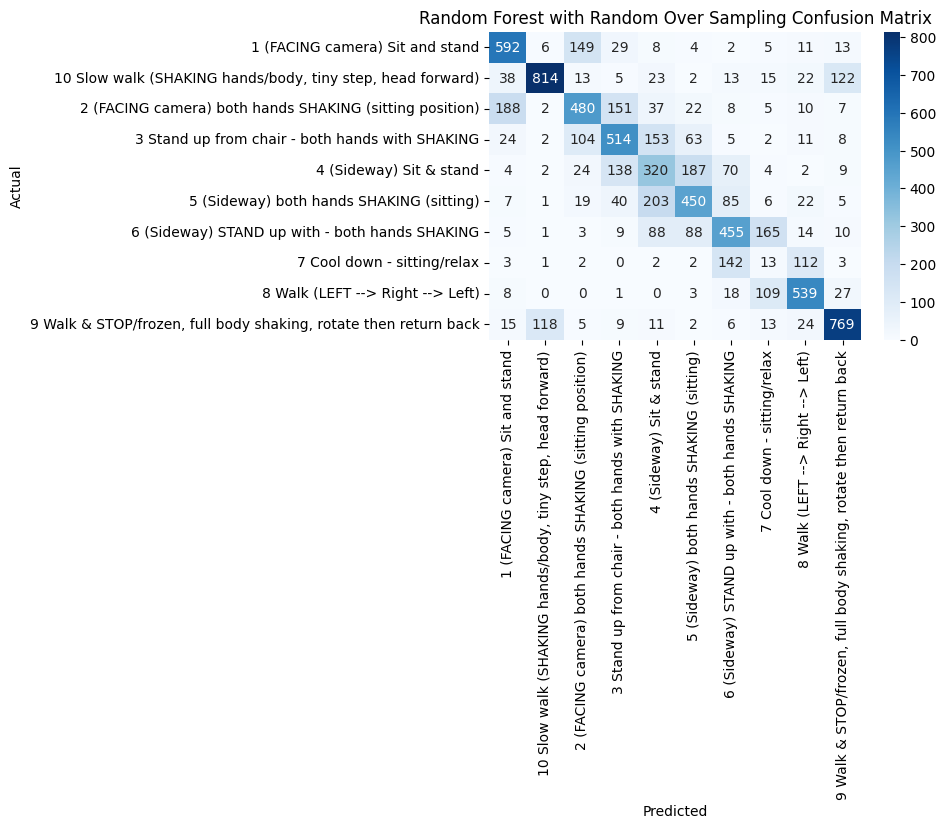

In [140]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rfc.fit(X_resampled, y_resampled)
# rfc.fit(X_train, y_train)
from sklearn.metrics import classification_report
y_predict = rfc.predict(X_test)
print(classification_report(y_test, y_predict))
plot_confusion_matrix(y_predict, 'Random Forest with Random Over Sampling')

# Extra Trees

                                                                  precision    recall  f1-score   support

                                 1 (FACING camera) Sit and stand       0.72      0.76      0.74       941
      10 Slow walk (SHAKING hands/body, tiny step, head forward)       0.78      0.78      0.78      1323
         2 (FACING camera) both hands SHAKING (sitting position)       0.67      0.58      0.62       990
                 3 Stand up from chair - both hands with SHAKING       0.59      0.63      0.61       967
                                         4 (Sideway) Sit & stand       0.45      0.55      0.50       766
                        5 (Sideway) both hands SHAKING (sitting)       0.49      0.39      0.43       933
                  6 (Sideway) STAND up with - both hands SHAKING       0.61      0.58      0.60       940
                                     7 Cool down - sitting/relax       0.06      0.05      0.05       309
                                8 Walk (LEFT 

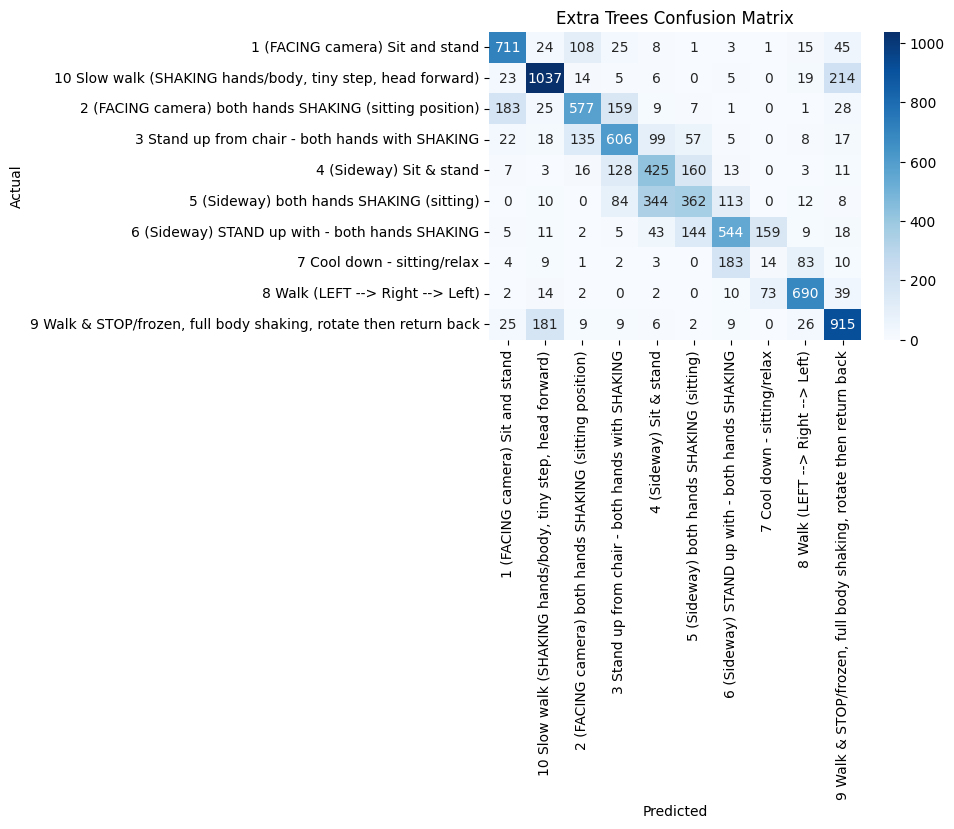

In [81]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier(n_estimators=500, n_jobs=-1)
# etc.fit(X_resampled, y_resampled)
etc.fit(X_train, y_train)
from sklearn.metrics import classification_report
y_predict = etc.predict(X_test)
print(classification_report(y_test, y_predict))
plot_confusion_matrix(y_predict, 'Extra Trees')

In [58]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test) # without resampling
# models, predictions = clf.fit(X_resampled, X_test, y_resampled, y_test) # with resampling

print(models)

  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10506
[LightGBM] [Info] Number of data points in the train set: 36728, number of used features: 44
[LightGBM] [Info] Start training from score -2.266961
[LightGBM] [Info] Start training from score -1.932066
[LightGBM] [Info] Start training from score -2.244616
[LightGBM] [Info] Start training from score -2.253131
[LightGBM] [Info] Start training from score -2.396970
[LightGBM] [Info] Start training from score -2.311830
[LightGBM] [Info] Start training from score -2.308812
[LightGBM] [Info] Start training from score -3.355898
[LightGBM] [Info] Start training from score -2.497621
[LightGBM] [Info] Start training from score -2.010841
                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                     